# Figure 4
data is stored in ../../data

# setup and load data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from dms_3d_features.plotting import (
    plot_pop_avg_from_row,
    publication_style_ax,
    plot_violins_w_percent,
    plot_motif_boxplot_stripplot,
    format_small_plot,
)

## extra functions

In [2]:
def plot_violinplot_with_percentages(df, y_column, color="tab:red", ax=None):
    # Calculate percentages
    percentages = (
        df.groupby(y_column)
        .apply(lambda x: (x["ln_r_data"] > -5.45).mean() * 100)
        .round(2)
    )

    # Sort y_column values by percentage
    sorted_y_values = percentages.sort_values(ascending=False).index

    if ax is None:
        fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
    else:
        fig = ax.figure

    sns.violinplot(
        data=df,
        x="ln_r_data",
        y=y_column,
        density_norm="width",
        color=color,
        linewidth=0.5,
        order=sorted_y_values,
        ax=ax,
    )
    ax.axvline(-5.45, color="black", linestyle="--", lw=0.5)

    # Add percentage labels
    for i, y_value in enumerate(sorted_y_values):
        ax.text(-9.7, i, f"{percentages[y_value]:.2f}%", va="center", ha="right")

    ax.set_xlim(-12.5, -3)
    ax.set_xticks([-10, -8, -6, -4, -2])
    ax.set_xlabel("ln(Mutation Fraction)", labelpad=2)
    y_label = ""
    if y_column == "p3_res":
        y_label = "3' Nucleotide"
    elif y_column == "p5_res":
        y_label = "5' Nucleotide"
    elif y_column == "r_stack":
        y_label = "Nucleotide Stack"
    ax.set_ylabel(y_label, labelpad=2)
    format_small_plot(ax)

    return fig, ax

In [3]:
def assign_stack_type(row):
    if row["both_pyrimidine"]:
        return "Pyrimidine"
    elif row["both_purine"]:
        return "Purine"
    else:
        return "Mixed"

### load data

In [4]:
DATA_PATH = "../../data/"

In [5]:
df_constructs = pd.read_json(f"{DATA_PATH}/raw-jsons/constructs/pdb_library_1.json")
df_constructs_nomod = pd.read_json(
    f"{DATA_PATH}/raw-jsons/constructs/pdb_library_nomod.json"
)
df = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues.json")
df["ln_r_data"] = np.log(df["r_data"])
df["ln_r_data"].replace(-np.inf, -9.8, inplace=True)

df = df.query("r_data_outlier == False").copy()
df_pdb = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues_pdb.json")
df_pdb["stack_type"] = df_pdb.apply(assign_stack_type, axis=1)

df_sasa = pd.read_csv(f"{DATA_PATH}/pdb-features/sasa.csv")
df_sasa["m_sequence"] = df_sasa["m_sequence"].apply(lambda x: x.replace("&", "_"))

df_merge = pd.merge(
    df_pdb, df_sasa, on=["m_sequence", "r_nuc", "pdb_r_pos", "pdb_path"]
)
df_merge = df_merge.query("not ln_r_data.isnull()")

/opt/homebrew/Caskroom/miniconda/base/envs/py3/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Plotting 

## Figure 4a

/opt/homebrew/Caskroom/miniconda/base/envs/py3/lib/python3.8/site-packages/dms_3d_features/plotting.py:426: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


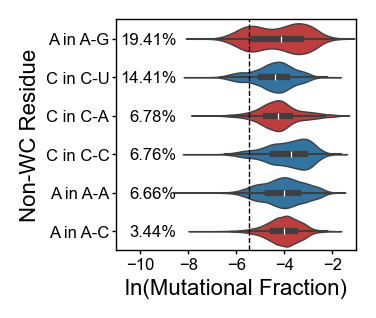

In [6]:
df_non_wc_pair = df.query(
    "r_type == 'NON-WC' and (r_nuc == 'A' or r_nuc == 'C') and likely_pair != ''"
).copy()
df_non_wc_pair = df_non_wc_pair.query("likely_pair != 'AU'")
df_non_wc_pair["cat"] = df_non_wc_pair.apply(
    lambda row: f"{row['r_nuc']} in {row['likely_pair'][0]}-{row['likely_pair'][1]}",
    axis=1,
)
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
plot_violins_w_percent(
    df_non_wc_pair,
    "ln_r_data",
    "cat",
    gt_lt="less",
    xlim=(-11, -1),
    text_offset=2.5,
    colors=["tab:red", "tab:blue", "tab:red", "tab:blue", "tab:blue", "tab:red"],
    sorted_by_mean=True,
    ax=ax,
)
ax.set_ylabel("Non-WC Residue", labelpad=2)
ax.set_xlabel("ln(Mutational Fraction)", labelpad=2)
ax.set_xticks([-10, -8, -6, -4, -2])
format_small_plot(ax)
plt.savefig("pngs/figure_4a.png", dpi=600)

/opt/homebrew/Caskroom/miniconda/base/envs/py3/lib/python3.8/site-packages/dms_3d_features/plotting.py:426: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


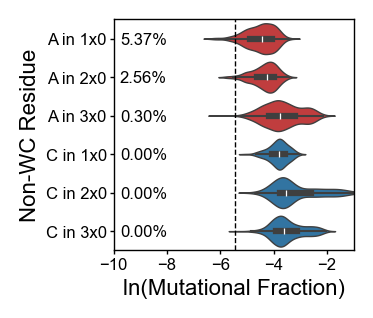

In [7]:
df_sub = df.query(
    "r_type == 'NON-WC' and m_token.str.endswith('x0') and r_type == 'NON-WC'"
).copy()
df_sub = df_sub.query("m_token != '5x0'")
df_sub["cat"] = df_sub.apply(
    lambda row: f"{row['r_nuc']} in {row['m_token']}",
    axis=1,
)
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
plot_violins_w_percent(
    df_sub,
    "ln_r_data",
    "cat",
    colors=["tab:red", "tab:red", "tab:red", "tab:blue", "tab:blue", "tab:blue"],
    gt_lt="less",
    xlim=(-10, -1),
    text_offset=2.0,
    ax=ax,
)
ax.set_ylabel("Non-WC Residue", labelpad=2)
ax.set_xlabel("ln(Mutational Fraction)", labelpad=2)
ax.set_xticks([-10, -8, -6, -4, -2])
format_small_plot(ax)
plt.savefig("pngs/figure_4b.png", dpi=600)

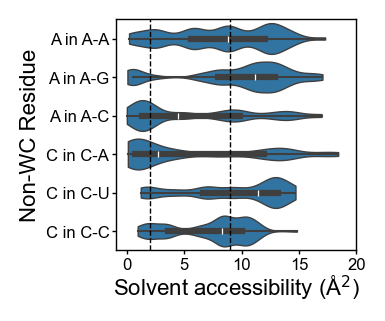

In [18]:
# get only the cats in 1x1
df_non_wc_pair = df_merge.query(
    "r_type == 'NON-WC' and (r_nuc == 'A' or r_nuc == 'C') and m_token == '1x1'"
).copy()
df_non_wc_pair["cat"] = df_non_wc_pair.apply(
    lambda row: f"{row['r_nuc']} in {row['likely_pair']}" if row["likely_pair"] else "",
    axis=1,
)
cats = list(df_non_wc_pair["cat"].unique())
df_non_wc_pair = df_merge.query(
    "r_type == 'NON-WC' and (r_nuc == 'A' or r_nuc == 'C')"
).copy()
df_non_wc_pair["cat"] = df_non_wc_pair.apply(
    lambda row: f"{row['r_nuc']} in {row['likely_pair']}" if row["likely_pair"] else "",
    axis=1,
)
# Filter df_non_wc_pair to only include rows where 'cat' is in cats
df_non_wc_pair = df_non_wc_pair[df_non_wc_pair["cat"].isin(cats)]
df_non_wc_pair["cat"] = df_non_wc_pair.apply(
    lambda row: f"{row['r_nuc']} in {row['likely_pair'][0]}-{row['likely_pair'][1]}",
    axis=1,
)
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
sns.violinplot(
    data=df_non_wc_pair,
    x="sasa_0_5",
    y="cat",
    density_norm="width",
    linewidth=0.5,
    cut=0,
    ax=ax,
)
ax.axvline(2, color="black", linestyle="--", linewidth=0.5)
ax.axvline(9, color="black", linestyle="--", linewidth=0.5)
format_small_plot(ax)
ax.set_xlabel("Solvent accessibility (Å$^2$)", labelpad=0)
ax.set_ylabel("Non-WC Residue", labelpad=2)
ax.set_xticks([0, 5, 10, 15, 20])
plt.savefig("pngs/figure_4c.png", dpi=600)

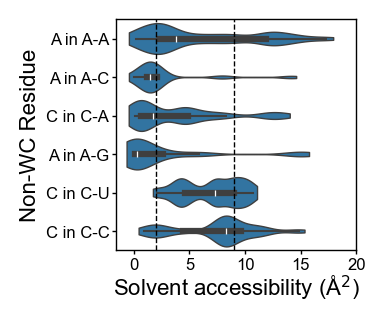

In [16]:
df_non_wc_pair = df_merge.query(
    "r_type == 'NON-WC' and (r_nuc == 'A' or r_nuc == 'C') and likely_pair != '' and m_token == '1x1'"
).copy()
df_non_wc_pair["cat"] = df_non_wc_pair.apply(
    lambda row: f"{row['r_nuc']} in {row['likely_pair'][0]}-{row['likely_pair'][1]}",
    axis=1,
)
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
sns.violinplot(
    data=df_non_wc_pair,
    x="sasa_0_5",
    y="cat",
    density_norm="width",
    linewidth=0.5,
    cut=0.5,
    ax=ax,
)
ax.axvline(2, color="black", linestyle="--", linewidth=0.5)
ax.axvline(9, color="black", linestyle="--", linewidth=0.5)

format_small_plot(ax)
ax.set_xlabel("Solvent accessibility (Å$^2$)", labelpad=2)
ax.set_ylabel("Non-WC Residue", labelpad=2)
ax.set_xticks([0, 5, 10, 15, 20])
plt.savefig("pngs/figure_4d.png", dpi=600)

/opt/homebrew/Caskroom/miniconda/base/envs/py3/lib/python3.8/site-packages/dms_3d_features/plotting.py:426: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


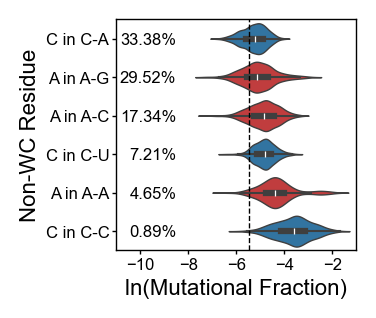

In [17]:
df_non_wc_pair = df.query(
    "r_type == 'NON-WC' and (r_nuc == 'A' or r_nuc == 'C') and likely_pair != '' and m_token == '1x1'"
).copy()
df_non_wc_pair["cat"] = df_non_wc_pair.apply(
    lambda row: f"{row['r_nuc']} in {row['likely_pair'][0]}-{row['likely_pair'][1]}",
    axis=1,
)
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
plot_violins_w_percent(
    df_non_wc_pair,
    "ln_r_data",
    "cat",
    gt_lt="less",
    xlim=(-11, -1),
    text_offset=2.5,
    colors=["tab:blue", "tab:red", "tab:red", "tab:blue", "tab:red", "tab:blue"],
    sorted_by_mean=True,
    ax=ax,
)
ax.set_ylabel("Non-WC Residue", labelpad=2)
ax.set_xlabel("ln(Mutational Fraction)", labelpad=2)
ax.set_xticks([-10, -8, -6, -4, -2])
format_small_plot(ax)
plt.savefig("pngs/figure_4e.png", dpi=600)

/opt/homebrew/Caskroom/miniconda/base/envs/py3/lib/python3.8/site-packages/dms_3d_features/plotting.py:438: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.violinplot(


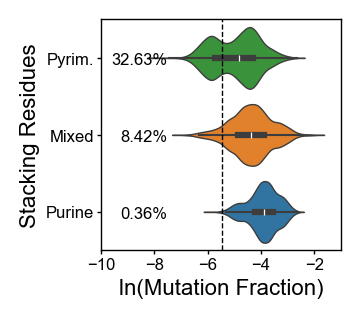

In [14]:
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
df_cu = df.query("r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CU'").copy()
df_cu["stack_type"] = df_cu.apply(assign_stack_type, axis=1)
ax = plot_violins_w_percent(
    df_cu,
    "ln_r_data",
    "stack_type",
    color=None,
    gt_lt="less",
    xlim=(-10, -1),
    sorted_by_mean=True,
    ax=ax,
)
ax.set_ylabel("Stacking Residues", labelpad=2)
ax.set_xlabel("ln(Mutation Fraction)", labelpad=2)
ax.set_yticks([0, 1, 2], labels=["Pyrim.", "Mixed", "Purine"])
ax.set_xticks([-10, -8, -6, -4, -2])
format_small_plot(ax)
plt.savefig("pngs/figure_4g.png", dpi=600)